## Remoção do Fundo

1. Utilizar uma imagem para teste

2. Imagem utilizada: `00-images/cl1_p1_psul_deixa1_g0005.jpg`

3. Retirar o fundo preto da imagem, mantendo a área de interesse

4. Tentativas:

> a) Florian's Blog - https://flothesof.github.io/removing-background-scikit-image.html

> b) Remove background colour from image using Python/PIL - https://stackoverflow.com/questions/21217384/remove-background-colour-from-image-using-python-pil

> c) Remove background with cv2

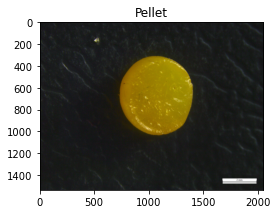

Tamanho da imagem: (1536, 2048, 3)
Tipo de imagem: uint8


In [1]:
#--- Abrindo o arquivo jpg ---#

from skimage import io #io é parte do skimage

import matplotlib.pyplot as plt

#--- Imagem para teste ---#

img = io.imread('/home/jbozz/Documentos/lapogeo_ufsc/TCC/Proj_Pellets_Amarelamento/notebooks/00-images/cl1_p1_psul_deixa1_g0005.jpg')

#--- Mostrar Imagem ---#
plt.figure(figsize=(4,4)) # definindo tamanho da imagem
plt.imshow(img)
plt.title('Pellet')
plt.show()

print("Tamanho da imagem: {}".format(img.shape)) 
print("Tipo de imagem: {}".format(img.dtype))

#imagens coloridas possuem .shape matriz 3D [altura, largura, cor (3)]

### a) Frolian's Blog

In [15]:
# Detecting the edges
from skimage import filters
sobel = filters.sobel(img)

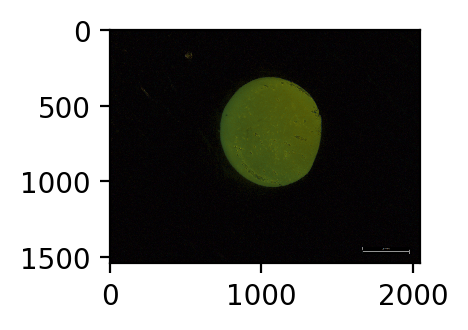

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi'] = 200

plt.figure(figsize=(2,2))
plt.imshow(sobel)

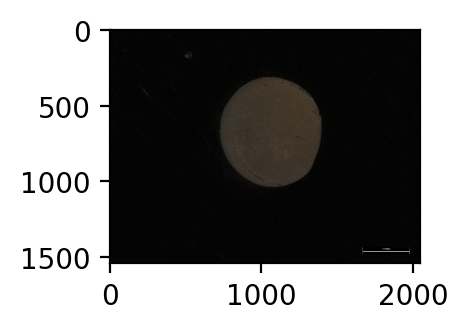

In [19]:
#Let's now blur this image a bit to make the edges thicker 
blurred = filters.gaussian(sobel, sigma=2.0, channel_axis = False)
plt.figure(figsize=(2,2))
plt.imshow(blurred)

In [20]:
#use dark and light zone properties of the image

import numpy as np
light_spots = np.array((img > 245).nonzero()).T
light_spots.shape

(37518, 3)

Text(0.5, 1.0, 'light spots in image')

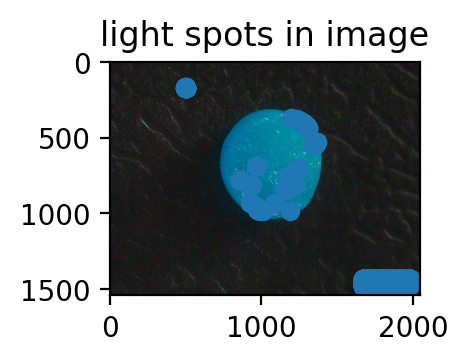

In [21]:
plt.figure(figsize=(2,2))
plt.plot(light_spots[:, 1], light_spots[:, 0], 'o')
plt.imshow(img)
plt.title('light spots in image')

In [22]:
dark_spots = np.array((img < 3).nonzero()).T
dark_spots.shape

(269082, 3)

Text(0.5, 1.0, 'dark spots in image')

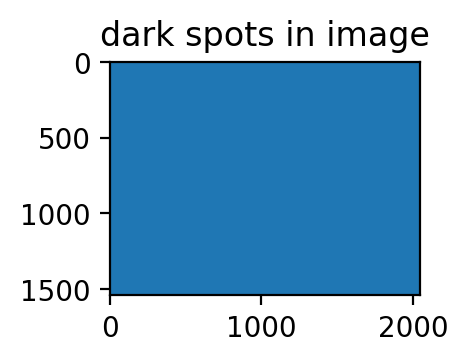

In [23]:
plt.figure(figsize=(2,2))
plt.plot(dark_spots[:, 1], dark_spots[:, 0], 'o')
plt.imshow(img)
plt.title('dark spots in image')

In [24]:
#Using the previous points, we can use the labelling function from scipy.ndimage to make a seed mask

from scipy import ndimage as ndi
bool_mask = np.zeros(img.shape, dtype=bool)
bool_mask[tuple(light_spots.T)] = True
bool_mask[tuple(dark_spots.T)] = True
seed_mask, num_seeds = ndi.label(bool_mask)
num_seeds

22802

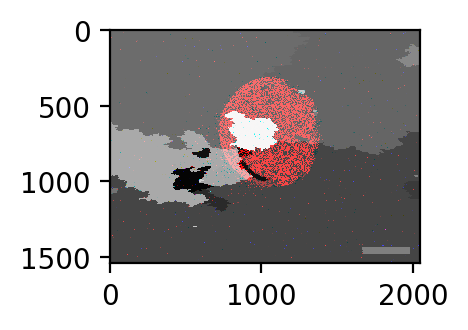

In [30]:
from skimage import morphology
from skimage.segmentation import watershed
ws = watershed(blurred, seed_mask)
plt.figure(figsize=(2,2))
plt.imshow(ws.astype('uint8'))

In [33]:
background = max(set(ws.ravel()), key=lambda g: np.sum(ws == g))
background_mask = (ws == background)

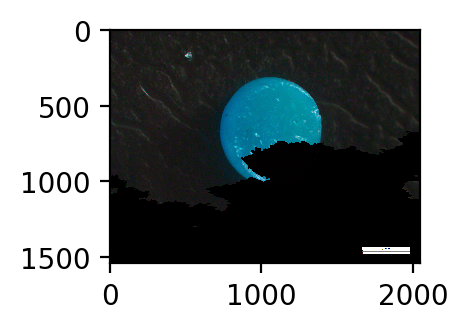

In [35]:
cleaned = img * ~background_mask
plt.figure(figsize=(2,2))
plt.imshow(cleaned)
plt.savefig('removebg-attempt-a.png')

### b) Python/PIL

In [2]:
import numpy as np
from PIL import Image

In [3]:
img = Image.open('/home/jbozz/Documentos/lapogeo_ufsc/TCC/Proj_Pellets_Amarelamento/notebooks/00-images/cl1_p1_psul_deixa1_g0005.jpg')
img = img.convert('RGBA')
data = np.array(img)
img_color = img.getpixel((10,15)) #pega o pixel de determinadas coordenadas
print(img_color)

(16, 25, 24, 255)


In [4]:
img_color2 = list(img.getdata())  #lista de pixel das imagens

[16, 25, 24]


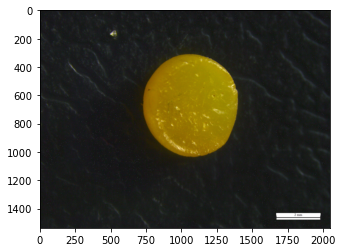

In [5]:
# just use the rgb values for comparison
rgb = data[:,:,:3]
color = list(img_color[:3])
print(color) # Original value
black = [0,0,0, 255]
white = [255,255,255,255]
mask = np.all(rgb == color, axis = -1)
# change all pixels that match color to white
data[mask] = white

# change all pixels that don't match color to black
##data[np.logical_not(mask)] = black
new_im = Image.fromarray(data)
new_im.save('removebg-attempt-b.png')

#imagem gerada (ainda com fundo)
plt.imshow(new_im)

### c) cv2

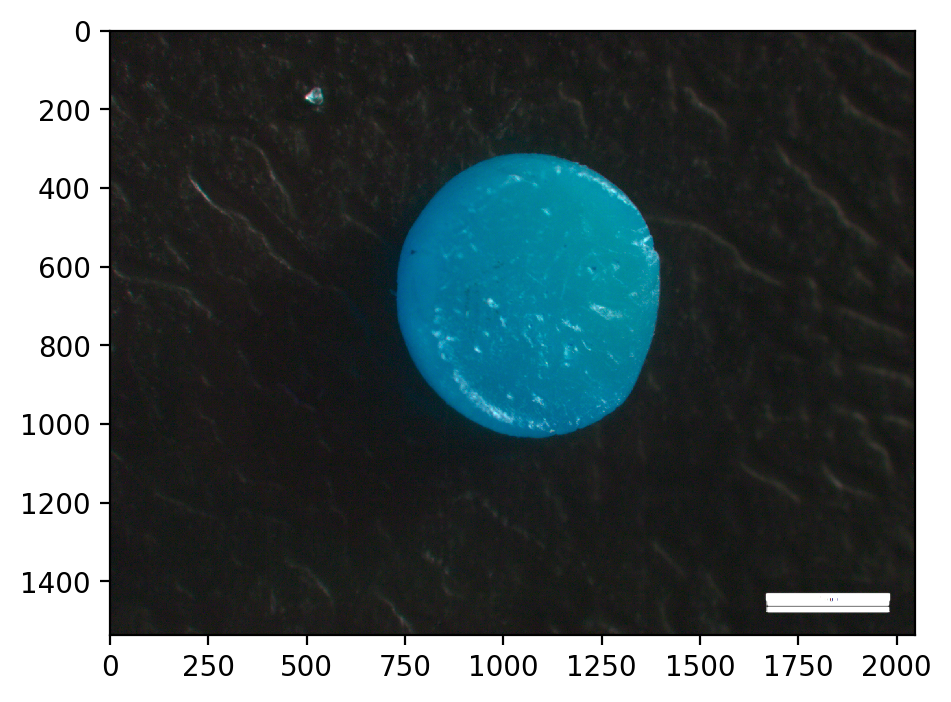

In [34]:
import cv2
import numpy as np

# load image
img = cv2.imread('/home/jbozz/Documentos/lapogeo_ufsc/TCC/Proj_Pellets_Amarelamento/notebooks/00-images/cl1_p1_psul_deixa1_g0005.jpg')

# convert to graky
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# threshold input image as mask
mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)[1]

# negate mask
mask = 255 - mask

# apply morphology to remove isolated extraneous noise
# use borderconstant of black since foreground touches the edges
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# anti-alias the mask -- blur then stretch
# blur alpha channel
mask = cv2.GaussianBlur(mask, (0,0), sigmaX=2, sigmaY=2, borderType = cv2.BORDER_DEFAULT)

# linear stretch so that 127.5 goes to 0, but 255 stays 255
mask = (2*(mask.astype(np.float32))-255.0).clip(0,255).astype(np.uint8)

# put mask into alpha channel
result = img.copy()
result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
result[:, :, 3] = mask

# save resulting masked image
cv2.imwrite('removebg-attempt-c.png', result)

# display result, though it won't show transparency
plt.imshow(result)